# Plotting the effect missing data has on the Naive Bayes classifier 

Date created: March 14, 2016   
Last modified: March 14, 2016  
Tags: Gaussian naive bayes, naive bayes, missing data  
About: small experiment to see effect missing data and training data size have on the naive bayes classifier

Real-world data sets are most often incomplete and [different strategies](https://www.amstat.org/sections/srms/webinarfiles/ModernMethodWebinarMay2012.pdf) have been developed to handle the [missing values](https://en.wikipedia.org/wiki/Missing_data). A simplifying assumption (that the data is missing completely at random --MCAR) is often made and the missing value is replaced by the mean value of the attribute, interpolated from the data available. An issue that arises with imputing data is the reliability of the classification results. The robustness of the classification model when data is imputed can be evaluated by sensitivity analysis.

In this example we look at classifier prediction metrics when missing data is imputed. Of the classifiers that are widely used, the Naive Bayes classifier is known to perform well both with small data sets and with missing data. For this experiment we take two data sets (the Fisher iris data set and the Wisconsin breast cancer data set, both of which are in the UCI repository) which have a full set of data and apply the Gaussian Naive Bayes algorithm. We control the  missing rate by progressively varying it from 0% to 75%. The prediction metrics of the classification model for each of these rates is plotted to see the robustness of the classifier. There are a number of evaluation metrics used in supervised learning. For this experiment we will plot two: the [Precision](https://en.wikipedia.org/wiki/Precision_and_recall) which is the percentage of the True Positives in a test result and the [F1 score](https://en.wikipedia.org/wiki/F1_score), which is the harmonic mean of precision and recall.

Methodologically we will generate a 67-33% train-test split of the data. The training data will be injected randomly with missing data with missing rate values set at 0%, 10%, 30%, 50% and 75%. We will then impute the missing instances with the mean value of the corresponding attribute. The <i>sklearn preprocessing</i> module automatically makes these computations. The results are measured on the test data using the predicted and actual response.


# Naive  Bayes  

The Naive Bayes (NB) supervised classification method is simple to implement yet it performs very well for certain classification tasks. The naive independence assumption means that interactions between variables can be ignored. This makes it a simpler model which needs less data than some other algorithms. The algorithm is also designed so that it naturally handles the missing data. This is because missing instances are not included in the individual probability computations. These defining characteristics make the NB technique robust to missing data and smaller sample sizes. 

In an experiment to assess the sensitivity of classifiers to missing data, Liu et al. <a href="#ref1">[1]</a> showed that of six standard classifiers, the NB had the best accuracy. The other classifiers showed an obvious decrease in accuracy when the proportion of missing data reached 20% but the NB maintained the same level of accuracy even at 70%. Ten different data sets were used to demonstrate the applicability of the results to a diverse set of data. A very similar result, also on ten data sets, was obtained by Blomberg et al. <a href="#ref2">[2]</a> in their experiments.

Here we will follow a similar procedure (outlined above) as they used in their experiments. We will use the Gaussian Naive Bayes algorithm since the data are obtained from  measurements, not counts. We will aslo make use of data sets (Iris, Breast cancer) used in one or both of the papers. 


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing  # for the Imputer function
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

## I. Iris data set  

The first data set we evaluate is the [Iris data set](https://en.wikipedia.org/wiki/Iris_flower_data_set), available in the UCI repository but also the <i>sklearn</i> package. This data set was first analyzed by Fisher and is often used as a test case for classification problems. Four feature measurements are used to classify three species of iris and classifiers such as naive bayes and logistic regression have been shown to achieve a high level of accuracy. 

Since the dataset is complete and has no missing values we will have to introduce the missing data. We do a 67-33% train-test split and randomly assign missing values to a set proportion of the training data which we control. We then impute the missing values with the mean value of the corresponding attribute. The classification model is fit to training data with imputed values. We then evaluate the classification accuracy on the test set.


In [3]:
from sklearn import datasets

dataset = datasets.load_iris()

X_full_iris = dataset.data
y_full_iris = dataset.target
print X_full_iris.shape[0]

150


First we run the classification when the data set is complete (and before the missing values are inserted). This gives us a baseline result.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_full_iris, y_full_iris, test_size=0.33, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        19
          1       0.93      0.93      0.93        15
          2       0.94      0.94      0.94        16

avg / total       0.96      0.96      0.96        50



At 0.96 the average precision, recall and f1 score are very high with the Gausian Naive Bayes classifier when there are no missing values. (We get a precision/recall/f1 score of 1.0 with the Logistic Regression --see the Appendix).  
We next evaluate the classification metircs when missing values are injected at different rates. Since the same steps are repeated for each missing rate, I've put all the steps in a function.

In [5]:

def gnb_classifier(X_full, y_full):
    
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full, test_size=0.33, random_state=42)
    n_samples = X_train.shape[0]
    n_features = X_train.shape[1]

    missing_rates = [0.0, 0.10, 0.30, 0.50, 0.75]
    precision = []
    fscore = []
    
    for missing_rate in missing_rates:
        
        # this is example code from missing_values.py at
        # http://scikit-learn.org/stable/auto_examples/missing_values.html
        rng = np.random.RandomState(0)

        n_missing_samples = np.floor(n_samples * missing_rate)
        missing_samples = np.hstack((np.zeros(n_samples - n_missing_samples, dtype=np.bool),
                                     np.ones(n_missing_samples, dtype=np.bool)))
        rng.shuffle(missing_samples)
        missing_features = rng.randint(0, n_features, n_missing_samples)
    
  
        # inject missing data into the training data set
        X_missing = X_train.copy()
        X_missing[np.where(missing_samples)[0], missing_features] = 0
        y_missing = y_train.copy()
        # impute missing data with the mean value
        imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=0, copy=False)
        X_missing_imp = imp.fit_transform(X_missing)

        # call the NB classifier
        # train the classifier on the imputed data
        gnb = GaussianNB()
        gnb.fit(X_missing_imp, y_missing)
        y_pred = gnb.predict(X_test)
        
        # compute the precision and fscore
        p = round(metrics.precision_score(y_test, y_pred, pos_label=None, average='micro'), 2)
        precision.append(p)
        f = round(metrics.f1_score(y_test, y_pred, pos_label=None, average='weighted'), 2)
        fscore.append(f)  
           
        print 'Missing rate: {}' .format(missing_rate)  
        print(metrics.classification_report(y_test, y_pred))
        
    return precision, fscore

<h4> Results</h4>

In [24]:
# call the classifier and evaluate perfomance 
# for five different missing rates
precision_iris, fscore_iris = gnb_classifier(X_full_iris, y_full_iris)

Missing rate: 0.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        19
          1       0.93      0.93      0.93        15
          2       0.94      0.94      0.94        16

avg / total       0.96      0.96      0.96        50

Missing rate: 0.1
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        19
          1       1.00      0.80      0.89        15
          2       0.84      1.00      0.91        16

avg / total       0.95      0.94      0.94        50

Missing rate: 0.3
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        19
          1       0.93      0.87      0.90        15
          2       0.88      0.94      0.91        16

avg / total       0.94      0.94      0.94        50

Missing rate: 0.5
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        19
          1      

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<h4>Results on much smaller data set (~65% of original data not used) </h4>  

Since the NB classifier is known to give good results even for small data sets, we create a data set where only ~25% of the original data is used to train the classifier (10% is test and 65% of the data is not used). 
For both this truncated data set and cases with a high missing-rate, a substantial portion of the data set is not used for training the classifier. We can compare the predictive performance for the two situations.

In [48]:
df_iris = pd.DataFrame(X_full_iris)
df_iris['class']= y_full_iris

# construct new iris data set from a third of the original data set
# randomly select a third of the rows from the original dataframe
rows = np.random.choice(df_iris.index.values, len(df_iris)/3)
small_df_iris = df_iris.ix[rows]

X = small_df_iris.values[:,:4]
y = small_df_iris.values[:,4]
# training data is ~25% of original Iris data set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=2718)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00         2
        1.0       0.80      1.00      0.89         4
        2.0       1.00      0.89      0.94         9

avg / total       0.95      0.93      0.94        15



## II. Wisconsin breast cancer data set

The UCI [Wisconsin breast cancer dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/) has a binary response (benign/malignant, encoded 2/4) and can be set up as a classification problem. This dataset has 699 records with 16 instances of missing data which we will remove so that we start with a full data set.  

Once again we will do a 67-33% train-test split, assign missing values to the training data, impute the missing values, apply the gaussian naive bayes classifier and finally assess the classifier accuracy on the test set.  


<h4> Preprocessing the data </h4>

In [25]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
dataset = pd.read_csv(url, header=None, usecols=list(range(1,11)))

dataset.head(2)

,1,2,3,4,5,6,7,8,9,10
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2


In [8]:
print dataset.dtypes

1      int64
2      int64
3      int64
4      int64
5      int64
6     object
7      int64
8      int64
9      int64
10     int64
dtype: object


In [26]:
# convert column 6 to a numeric
dataset[6] = dataset[6].convert_objects(convert_numeric=True)
# "convert_objects" is deprecated but the alternative, 
# "pd.to_numeric" seems to have issues of its own
#pd.to_numeric(dataset[6])
#dataset.apply(pd.to_numeric, errors='ignore')
print dataset.dtypes

1       int64
2       int64
3       int64
4       int64
5       int64
6     float64
7       int64
8       int64
9       int64
10      int64
dtype: object


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [27]:
# remove the 16 missing values (2% of the dataset)
print 'size before removing missing data: {}' .format(dataset.shape[0])
dataset.dropna(how='any', inplace=True)
print 'size after removing missing data: {}' .format(dataset.shape[0])

size before removing missing data: 699
size after removing missing data: 683


<h4>Results</h4>

In [31]:
X_full_breastcancer = dataset.loc[:,0:9].values
y_full_breastcancer = dataset[10].values

# call the classifier 
# evaluate perfomance for five different missing rates
precision_breastcancer, fscore_breastcancer = gnb_classifier(X_full_breastcancer, y_full_breastcancer)

Missing rate: 0.0
             precision    recall  f1-score   support

          2       0.98      0.97      0.98       142
          4       0.95      0.96      0.96        84

avg / total       0.97      0.97      0.97       226

Missing rate: 0.1
             precision    recall  f1-score   support

          2       0.98      0.97      0.98       142
          4       0.95      0.96      0.96        84

avg / total       0.97      0.97      0.97       226

Missing rate: 0.3
             precision    recall  f1-score   support

          2       0.99      0.97      0.98       142
          4       0.95      0.98      0.96        84

avg / total       0.97      0.97      0.97       226

Missing rate: 0.5
             precision    recall  f1-score   support

          2       0.99      0.97      0.98       142
          4       0.95      0.99      0.97        84

avg / total       0.98      0.98      0.98       226

Missing rate: 0.75
             precision    recall  f1-score   supp

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## III. Plotting the Precision vs the Missing Rate for the two data sets

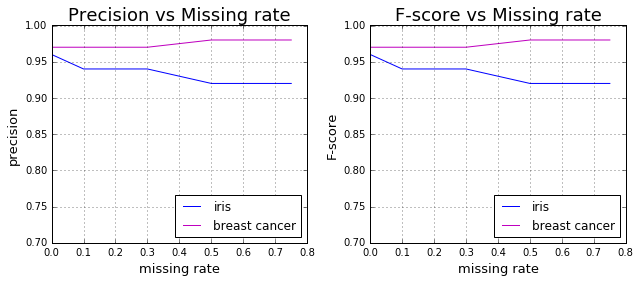

In [64]:
missing_rates = [0.0, 0.10, 0.30, 0.50, 0.75]
fig=plt.figure(figsize=(9,4))

plt.subplot(1, 2, 1)
plt.plot(missing_rates, precision_iris, label='iris')
plt.plot(missing_rates, precision_breastcancer, 'm', label='breast cancer')
plt.ylim(0.7,1)
plt.ylabel('precision', fontsize=13)
plt.xlabel('missing rate', fontsize=13)
plt.title('Precision vs Missing rate', fontsize=18)
plt.grid()
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(missing_rates, fscore_iris, label='iris')
plt.plot(missing_rates, fscore_breastcancer, 'm', label='breast cancer')
plt.ylim(0.7,1)
plt.ylabel('F-score', fontsize=13)
plt.xlabel('missing rate', fontsize=13)
plt.title('F-score vs Missing rate', fontsize=18)
plt.grid()
plt.legend(loc='lower right')

plt.tight_layout()

## Discussion    

The plots show that there is no significant loss in predictive performance as the controlled missing-rates vary from 0 to 75% for the two data sets. These results are in line with those reported in [1] and [2] for ten data sets.

For the iris data, we have the baseline value of 0.96 (precision/recall/f1 score) when there are no missing values. This indicates that the gaussian naive bayes is a good classifier for the data set. Furthermore, we are able to achieve a classification accuracy in the 0.95 range when significantly less data is used (we train with 35/150 records or about 25% of the original data set). The high predictive performance of another classifier --the Logistic Regression-- at 1.0 (see Appendix) indicates that this data set can be easily classified as well. In short, we expect good results from this data set and this classifier and the results with the missing data should be assessed in this context. 

We carried out this small experiment to get an insight into the effect missing data and training data size had on the classification performance of the naive bayes classifier. A full-scale study would involve an average over different training samples and a larger matrix of data sets which vary in number of attributes, classes, data instances and feature correlations. 

## Appendix   

For comparison purposes we use Logistic Regression to classify the Iris data set with no missing values.

In [65]:
# Using the Iris data set with no missing values

from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    X_full_iris, y_full_iris, test_size=0.33, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)
print(model)
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        19
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        16

avg / total       1.00      1.00      1.00        50



## References and Further Reading

<a name="ref1"></a>[1] [Liu, P., Lei, L. and Wu, N. (2005). A Quantitative Study of the Effect of Missing Data in Classifiers. Proc. of IEEE CIT:28:33](http://bb2.shufe.edu.cn/bbcswebdav/institution/%E4%BF%A1%E6%81%AF%E5%AD%A6%E9%99%A2/teacherweb/2000000629/mypapers/cit2005.pdf)  
<a name="ref2"></a>[2] [Blomberg, L.C., Ruiz, D.D.A. (2013). Evaluating the influence of missing data on classification algorithms in data mining applications. In SBSI 2013](http://www.lbd.dcc.ufmg.br/colecoes/sbsi/2013/0066.pdf)  
[3] Allision, P. [Modern Methods for Missing Data](https://www.amstat.org/sections/srms/webinarfiles/ModernMethodWebinarMay2012.pdf)

<div style="background-color: #FAAC58; margin-left: 0px; margin-right: 20px; padding-bottom: 8px; padding-left: 8px; padding-right: 8px; padding-top: 8px;">


Author:  Meena Mani  <br>
email:   meenas.mailbag@gmail.com   <br> 
twitter: @meena_uvaca    <br>
</div>